In [15]:
import xara
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy
%matplotlib inline

In [2]:
cwavel = 0.5e-6 # Wavelength [m]
ISZ = 128# Array size (number of pixel on a side)
pscale = 0.1 # plate scale [mas/pixel]
m2pix = xara.core.mas2rad(pscale) * ISZ / cwavel  # [1/m] units for (u, v) Fourier space

In [3]:
circle_mask = np.zeros((21, 2))
for i in range(21):
    circle_mask[i,0] = (100 + 10*np.random.normal())*np.cos(2*np.pi*i/21)
    circle_mask[i,1] = (100 + 10*np.random.normal())*np.sin(2*np.pi*i/21)
kpi = xara.KPI(array=circle_mask)

Attempting to build KPI from array None
210 distinct baselines were identified
10 first singular values for this array:
[4.58258 4.58258 4.58258 4.58258 4.58258 4.58258 4.58258 4.58258 4.58258
 4.58258]

        Summary of properties for no_name
        ---------------------------------------------------------------
        -  21 sub-apertures
        - 210 distinct baselines
        - 190 Ker-phases (90.5 % target phase information recovery)
        -  20 Eig-phases (95.2 % wavefront information recovery)
        ---------------------------------------------------------------
        
KPI data successfully created


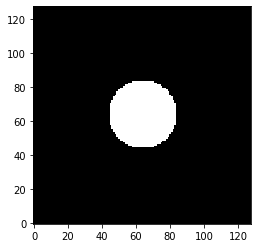

In [10]:
image_coords = np.arange(128) - 128 / 2.
xx, yy = np.meshgrid(image_coords, image_coords)
image = np.zeros_like(xx)
rho_squared = (xx) ** 2 + (yy) ** 2
image += rho_squared**(1/2) < 20
plt.imshow(image, cmap="gray")

array([[1.37063627e-01, 1.39703419e-01, 7.04220732e-02, ...,
        5.93316094e+00, 5.93611497e+00, 5.95027471e+00],
       [1.38755619e-01, 1.41464347e-01, 7.22532668e-02, ...,
        6.14372838e+00, 6.14674716e+00, 6.16121717e+00],
       [8.20983221e-02, 8.59061881e-02, 5.56809137e-02, ...,
        1.33601638e+00, 1.33604493e+00, 1.33617997e+00],
       ...,
       [4.95486118e-02, 4.68048017e-02, 2.45266007e-03, ...,
        1.35191239e-01, 1.35175220e-01, 1.35098354e-01],
       [7.97284044e-02, 7.87785891e-02, 3.25103912e-02, ...,
        1.57458821e-01, 1.57441550e-01, 1.57358692e-01],
       [9.27980608e-02, 9.47056957e-02, 3.66375469e-02, ...,
        1.80022735e-01, 1.80958088e-01, 1.85443336e-01]])

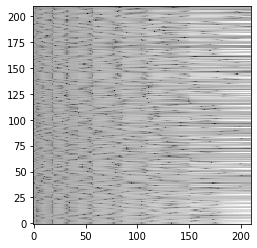

In [14]:
LL = xara.core.compute_DFTM2(kpi.UVC[:, 1], m2pix, ISZ, 0)
RR = xara.core.compute_DFTM2(kpi.UVC[:, 0], m2pix, ISZ, 1)
V = LL.dot(image).dot(RR)
amp = np.absolute(V)
plt.imshow(np.log(amp), cmap="gray")
amp

In [325]:
def objective_function(B,  f, minB=1e-3):
    # B should be positive definite
    mask = np.where(B <= 0)
    B[mask] = minB

def phase_closure_operator(kpi):
    """
    Function to work with xara KPI object, computes the phase closure operator.
    N: Number of apertures in the mask
    V_shape: Number of independant Complex Visibilities
    BLM: Baseline Mapping: matrix of size (q, N) with +1 and -1 mapping V to a pair of aperture (kpi.BLM from xara package)
    """
    N = kpi.nbap # number of apertures in the mask
    BLM = kpi.BLM
    triangles = N * (N-1) * (N-2) // 6
    print(f"There are {triangles} triangles to look at")
    p = (N-1)*(N-2)//2 # number of independant closure phases
    print(f"There are {p} independant closure phases")
    q = kpi.nbuv # number of independant visibilities phases
    A = np.zeros((triangles, q)) # closure phase operator satisfying A*(V phases) = (Closure Phases)
    A_index = 0 # index for A_temp
    for i in range(N):
        for j in range(i + 1, N): # i, j, and k select a triangle of apertures
            # k index is vectorized
            k = np.arange(j + 1, N)
            if k.size == 0:
                break
            # find baseline indices b1, b2 and b3 from triangle i,j,k by searching for the row index where two index were paired in Baseline Map
            b1 = np.nonzero((BLM[:, i] != 0) & (BLM[:, j] != 0))[0][0] # should be a single index
            b1 = np.repeat(b1, k.size) # therefore put in an array to match shape of b2 and b3
            # b2k and b3k keep track of which triangle the baseline belongs to (since indices are returned ordered by numpy nonzero)
            # in other words, the baselines b2 are associated with pairs of apertures j and k[b2k]
            b2, b2k = np.nonzero((BLM[:, k] != 0) & (BLM[:, j] != 0)[:, np.newaxis]) # index is broadcasted to shape of k
            b3, b3k = np.nonzero((BLM[:, k] != 0) & (BLM[:, i] != 0)[:, np.newaxis])
            diag = np.arange(A_index, A_index + k.size)
            # signs are retrieved from Baseline Map in order to satisfy closure relation: (i - j) + (j - k) + (k - i)
            A[diag, b1] += BLM[b1, i]
            A[diag, b2] += BLM[b2, j]
            A[diag, b3] += BLM[b3, k[b3k]]
            # Sanity check that this works: closure relation should always return 0 for any three objects (1,2,3)
            assert np.array_equal(
                A[diag, b1] * (BLM[b1, i] * 1 + BLM[b1, j] * 2) \
                   + A[diag, b2] * (BLM[b2, j] * 2 + BLM[b2, k[b2k]] * 3)\
                   + A[diag, b3] * (BLM[b3, i] * 1 + BLM[b3, k[b3k]] * 3),
                np.zeros(k.size)
            ), f"Closure relation is wrong!"
            A_index += k.size
    print('Doing sparse svd')
    rank = np.linalg.matrix_rank(A.astype('double'), tol=1e-6)
    print("Closure phase operator matrix rank:", rank)
    print(f"Discards the {rank - p} smallest singular values")
    u, s, vt = scipy.sparse.linalg.svds(A.astype('double').T, k=rank)
    print(f"Closure phase projection operator U shape {u.T.shape}")
    return u.T